# Прогнозирование цен на жилье - задача регрессии

Простой, но сложный проект для прогнозирования цены на жилье на основе определенных факторов, таких как площадь дома, спальни, меблировка, близость к главной дороге и т.д. Набор данных пока небольшой, его сложность возникает из-за того, что он обладает сильной мультиколлинеарностью.  

Оценка стоимости жилья полезна для всех участников рынка недвижимости, включая покупателей, продавцов, инвесторов, риелторов и финансовые учреждения.

## О наборе данных

| Признак на английском | Перевод на русский | Расшифровка на русском |
|---|---|---|
| area | площадь | площадь дома в квадратных футах |
| bedrooms | спальни | количество спален в доме |
| bathrooms | ванные комнаты | количество ванных комнат в доме |
| stories | этажи | количество этажей в доме |
| mainroad | главная дорога | находится ли дом на главной дороге (1) или нет (0) |
| guestroom | гостевая комната | есть ли в доме гостевая комната (1) или нет (0) |
| basement | подвал | есть ли в доме подвал (1) или нет (0) |
| hotwaterheating | горячее водоснабжение | есть ли в доме горячее водоснабжение (1) или нет (0) |
| airconditioning | кондиционер | есть ли в доме кондиционер (1) или нет (0) |
| parking | парковка | есть ли у дома парковка (1) или нет (0) |
| prefarea | предпочтительный район | находится ли дом в предпочитаемом районе (1) или нет (0) |
| furnishingstatus | состояние мебели | состояние мебели в доме (без мебели, с мебелью) |

**Target variable (целевая переменная): price (цена жилья)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/Housing.csv')
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
data.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [ ]:
data.describe(include="object")

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


 # Data preprocessing

In [ ]:
# Создадим словарь для сопоставления категориальных значений с числовыми значениями.
mapping = {
    "yes": 1,
    "no": 0,
}

# Используем словарь для замены категориальных значений на числовые значения.
data["mainroad"] = data["mainroad"].map(mapping)
data["guestroom"] = data["guestroom"].map(mapping)
data["basement"] = data["basement"].map(mapping)
data["hotwaterheating"] = data["hotwaterheating"].map(mapping)
data["airconditioning"] = data["airconditioning"].map(mapping)
data["prefarea"] = data["prefarea"].map(mapping)

In [ ]:
unique_values = data["furnishingstatus"].unique()
unique_values

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(data["furnishingstatus"])

data["furnishingstatus"] = le.transform(data["furnishingstatus"])

In [ ]:
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,2
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,2
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0


# Exploratory Data Analysis (EDA)

In [ ]:
data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [ ]:
data.corr() # корреляционная матрица (по умолчанию по Пирсону)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.296898,0.255517,0.187057,0.093073,0.452954,0.384394,0.329777,-0.304721
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,-0.171445
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,-0.123244
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,-0.143559
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,-0.104672
mainroad,0.296898,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,-0.156726
guestroom,0.255517,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,-0.118328
basement,0.187057,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,-0.112831
hotwaterheating,0.093073,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,-0.031628
airconditioning,0.452954,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,-0.150477


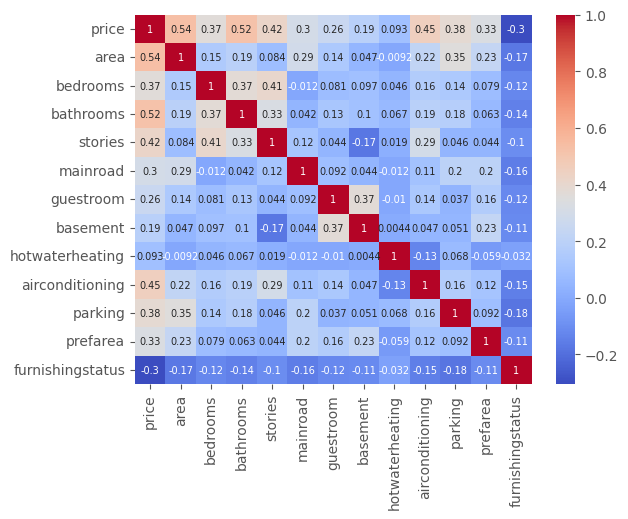

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", annot_kws={"size": 7})

plt.show()

Из построения корреляционной матрицы видим, что основное влияние на целевую переменную оказывают 3 признака: area, bathrooms, airconditioning. Попробуем использовать признак area, оказывающий наибольшее влияние на целевую переменную, для построения модели однофакторной полиноминальной регрессии.

# Model Train and Predict

# Обучение модели ОДНОФАКТОРНОЙ полиноминальной регрессии

In [ ]:
X = data['area']
y = data['price']

In [ ]:
X

0      7420
1      8960
2      9960
3      7500
4      7420
       ... 
540    3000
541    2400
542    3620
543    2910
544    3850
Name: area, Length: 545, dtype: int64

Построим график зависимости этих показателей, по линейной регрессии

(0.0, 13877500.0)

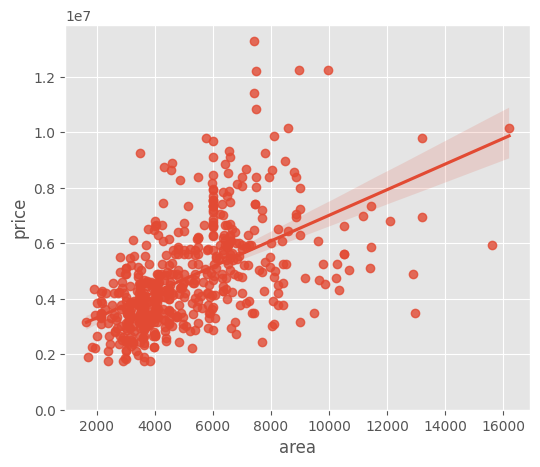

In [ ]:
import seaborn as sns
%matplotlib inline
width = 6
height = 5
plt.figure(figsize=(width, height))
sns.regplot(x="area", y="price", data=data, order=1)


plt.ylim(0,)

(0.0, 13877500.0)

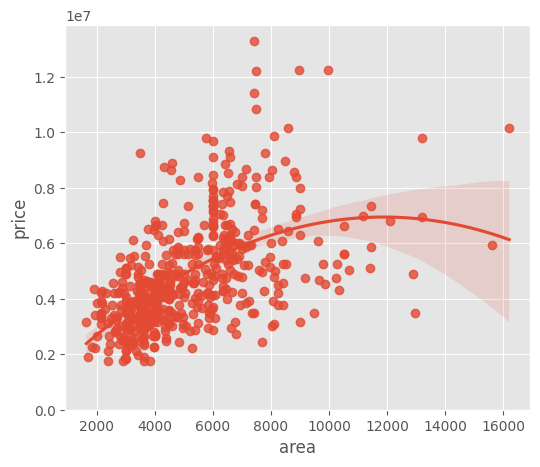

In [ ]:
import seaborn as sns
%matplotlib inline
width = 6
height = 5
plt.figure(figsize=(width, height))
sns.regplot(x="area", y="price", data=data, order=2)


plt.ylim(0,)

(0.0, 54681106.08497957)

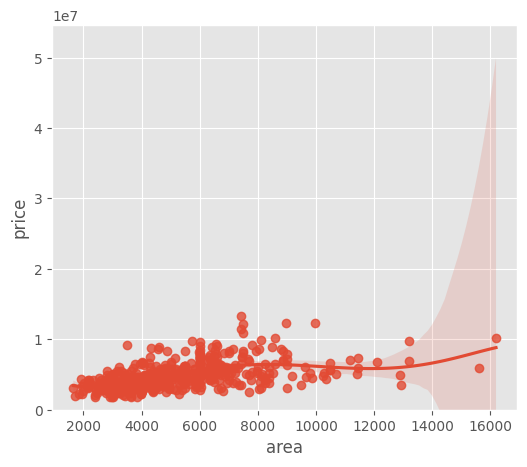

In [ ]:
import seaborn as sns
%matplotlib inline
width = 6
height = 5
plt.figure(figsize=(width, height))
sns.regplot(x="area", y="price", data=data, order=6)


plt.ylim(0,)

На визуализации видно, что данные на самом деле не линейно зависимые. При увеличении степени полинома график функции лучше проходит через наши данные

# Полиномиальное преобразование

## Полином 2-ой степени

In [ ]:
pf=PolynomialFeatures()  # степень 2 по умолчанию
X_poly = pf.fit_transform(np.array(X).reshape((len(X), 1))) # преобразование необходимо только для одномерного вектора признаков
lr = LinearRegression()
lr.fit(X_poly, y)
yp=lr.predict(X_poly)

In [ ]:
lr.score(X_poly, y)
s_1 = lr.score(X_poly, y)

In [ ]:
mape = mean_absolute_percentage_error(y, yp)
print('Mean absolute percentage error (MAPE) = ', mape)
m_1 = mape

Mean absolute percentage error (MAPE) =  0.2613681872826907


In [ ]:
w=lr.coef_
b=lr.intercept_
w, b

(array([ 0.00000000e+00,  1.03518489e+03, -4.35645185e-02]), 795440.7576162522)

## Полином 6-ой степени

In [ ]:
pf=PolynomialFeatures(degree=6)  # степень 2 по умолчанию
X_poly = pf.fit_transform(np.array(X).reshape((len(X), 1))) # преобразование необходимо только для одномерного вектора признаков
lr = LinearRegression()
lr.fit(X_poly, y)
yp=lr.predict(X_poly)

In [ ]:
lr.score(X_poly, y)
s_2 = lr.score(X_poly, y)

In [ ]:
mape = mean_absolute_percentage_error(y, yp)
print('Mean absolute percentage error (MAPE) = ', mape)
m_2 = mape

Mean absolute percentage error (MAPE) =  0.25598798484104884


In [ ]:
w=lr.coef_
b=lr.intercept_
w, b

(array([ 0.00000000e+00, -5.64064237e-07,  1.96620815e-08,  5.43869751e-05,
        -1.01828407e-08,  6.45704775e-13, -1.34988464e-17]),
 2652657.605386982)

## Кросс-валидация с использованием полиномиально преобразованного признака (полином 6-ой степени)

### Стандартная реализация кросс-валидации

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring="r2")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV R2 = %.4f" % np.mean(cv_scores))
s_3 = np.mean(cv_scores)

cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_percentage_error))
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MAPE = %.4f" % np.mean(cv_scores))
m_3 = np.mean(cv_scores)

Cross validation scores:
	 0.3702
	0.1125
	0.4036
	0.4240
	0.3635
Mean CV R2 = 0.3348
Cross validation scores:
	 0.2183
	0.2126
	0.2374
	0.2652
	0.2187
Mean CV MAPE = 0.2304


### Альтернативная реализация кросс-валидации через k-fold

In [ ]:
from sklearn.model_selection import KFold
scores = []
model = LinearRegression()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X_poly):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    model.fit(np.array(X_train).reshape((len(X_train), 1)), y_train)
    scores.append(model.score(np.array(X_test).reshape((len(X_test), 1)), y_test))
print (scores, np.mean(scores))
s_4 = np.mean(scores)

Train Index:  [  1   3   4   5   7   8  12  13  14  16  17  19  20  21  23  24  25  26
  27  28  29  31  32  34  35  36  37  38  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  56  57  58  59  60  61  62  64  65  66  67  69
  71  74  80  81  85  87  88  91  92  93  94  95  96  97  98  99 100 102
 103 105 106 107 108 109 110 111 112 113 114 115 116 118 119 120 121 122
 123 124 125 126 127 128 129 130 132 133 134 135 136 138 139 141 142 143
 144 145 146 147 150 151 152 154 156 157 159 160 161 162 164 165 166 167
 168 169 170 171 172 173 175 177 178 179 180 181 183 186 187 188 189 190
 191 192 193 194 195 196 197 198 200 201 202 203 204 205 206 207 211 212
 213 214 215 216 217 219 220 221 222 223 224 226 227 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 246 248 250 251 252 253 254
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 272 273 275
 276 277 278 279 280 281 282 283 285 286 287 288 289 290 291 292 293 294
 295 297 298 299 300 301 302 303 306 

In [ ]:
y_pred = model.predict(np.array(X_test).reshape((len(X_test), 1)))
print(model.predict(np.array(X_test).reshape((len(X_test), 1))))
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Средний процент отклонения  (MAPE) = ', mape)
m_4 = mape

[6444059.03930279 6061617.84977905 4016002.1848846  5928208.13250332
 4380655.41210492 5641377.24036051 5501297.037221   5372334.31052114
 5127749.82884897 5768116.47177245 5127749.82884897 4749755.62990109
 5874844.24559303 7429067.45185522 5127749.82884897 5127749.82884897
 4220563.75137405 5754775.50004488 5461274.12203829 5127749.82884897
 4905400.3000561  4460701.24247035 4883165.34717681 5675174.36873703
 4594110.95974608 5572448.88643472 5527978.98067615 5221136.63094198
 5172219.73460755 5928208.13250332 5172219.73460755 4033790.14718803
 5839268.32098617 7217835.39950199 4280598.12414812 5261159.5461247
 3793652.65609173 3980426.26027774 4393996.38383249 5145537.7911524
 5511080.41648789 3735841.77860558 4131623.9398569  3593538.08017814
 3993767.23200532 6844288.19112996 5287841.48957984 4224121.34383473
 4638580.86550465 4193881.8079189  4460701.24247035 4016002.1848846
 4416231.33671178 5287841.48957984 3493480.79222135 4273482.93922675
 4460701.24247035 4611898.92204951 42

## Скользящий контроль (leave-one-out) с использованием полиномиально преобразованного признака (полином 6-ой степени)

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression

# Initialize the model and the cross-validation object
model = LinearRegression()
loo = LeaveOneOut()

# Initialize an empty list to store the scores
scores = []

# Loop through each fold of the cross-validation
for train_index, test_index in loo.split(X_poly):
    # Split the data into training and testing sets
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = model.predict(X_test)

# Метрику score для однофакторной модели при использовании этого подхода вычислить не представляется возможным
# Calculate and print the mean absolute percentage error
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Средний процент отклонения  (MAPE) = ', mape)
m_5 = mape

Средний процент отклонения  (MAPE) =  1.301573444461658


# Обучение модели МНОГОФАКТОРНОЙ полиноминальной регрессии (на всех признаках)


In [ ]:
X = data[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus']]

y = data['price']

In [ ]:
X

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,1,0,0,0,1,2,1,0
1,8960,4,4,4,1,0,0,0,1,3,0,0
2,9960,3,2,2,1,0,1,0,0,2,1,1
3,7500,4,2,2,1,0,1,0,1,3,1,0
4,7420,4,1,2,1,1,1,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,1,0,1,0,0,2,0,2
541,2400,3,1,1,0,0,0,0,0,0,0,1
542,3620,2,1,1,1,0,0,0,0,0,0,2
543,2910,3,1,1,0,0,0,0,0,0,0,0


Построим график зависимости этих показателей, по линейной регрессии

(0.0, 13877500.0)

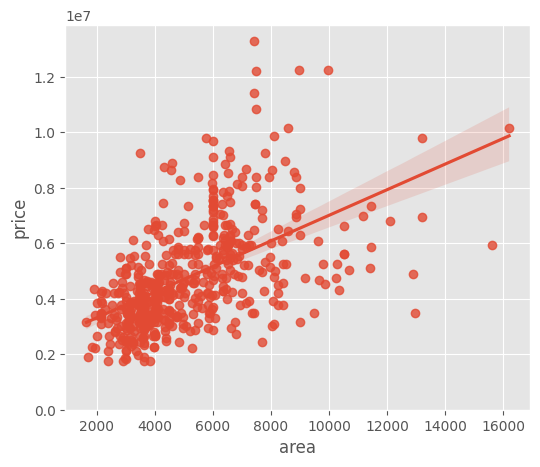

In [ ]:
import seaborn as sns
%matplotlib inline
width = 6
height = 5
plt.figure(figsize=(width, height))
sns.regplot(x="area", y="price", data=data, order=1)


plt.ylim(0,)

(0.0, 13877500.0)

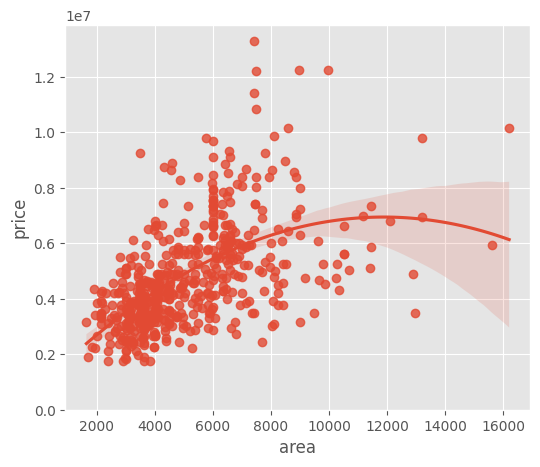

In [ ]:
import seaborn as sns
%matplotlib inline
width = 6
height = 5
plt.figure(figsize=(width, height))
sns.regplot(x="area", y="price", data=data, order=2)


plt.ylim(0,)

(0.0, 41585632.78630779)

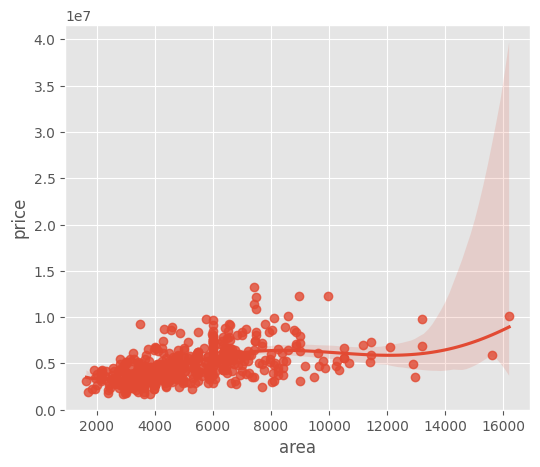

In [ ]:
import seaborn as sns
%matplotlib inline
width = 6
height = 5
plt.figure(figsize=(width, height))
sns.regplot(x="area", y="price", data=data, order=5)


plt.ylim(0,)

На визуализации видно, что данные на самом деле не линейно зависимые. При увеличении степени полинома график функции лучше проходит через наши данные

# Полиномиальное преобразование

## Полином 2-ой степени

In [ ]:
pf=PolynomialFeatures()  # степень 2 по умолчанию
X_poly = pf.fit_transform(np.array(X))
lr = LinearRegression()
lr.fit(X_poly, y)
yp=lr.predict(X_poly)

In [ ]:
lr.score(X_poly, y)
s_6 = lr.score(X_poly, y)

In [ ]:
mape = mean_absolute_percentage_error(y, yp)
print('Mean absolute percentage error (MAPE) = ', mape)
m_6 = mape

Mean absolute percentage error (MAPE) =  0.14849141761033813


In [ ]:
w=lr.coef_
b=lr.intercept_
w, b

(array([-8.11629226e-03,  1.80944400e+02,  7.42558578e+05, -7.08023337e+05,
         1.77539270e+05, -3.66839367e+05,  3.57715537e+05,  1.04347320e+05,
        -7.52231149e+05,  4.20295261e+04, -9.59551201e+04, -8.07516246e+05,
         4.40400815e+05, -1.47611330e-02, -1.53346780e+01,  1.34350825e+02,
        -9.17255393e+00,  1.32042216e+02, -3.18701097e+02,  1.43975490e+02,
        -2.29317108e+02,  2.93649235e+01, -1.24462970e+01,  6.15058702e+00,
        -9.19503370e+00, -3.17782308e+04, -4.31659520e+04, -5.63303597e+04,
        -1.65243048e+04,  1.52987132e+05, -9.12362835e+03,  1.40194180e+06,
        -6.27175637e+04,  8.69706387e+04, -7.22276077e+04, -1.82696171e+05,
         1.74664060e+05, -2.02237411e+05,  3.35868824e+05, -9.98796038e+04,
        -3.53939297e+05, -5.90167243e+05,  4.90237058e+05,  8.98711690e+04,
         3.68146470e+05,  4.14575154e+05,  5.97060813e+04,  2.13136075e+05,
        -1.48112913e+05,  1.82736476e+04, -4.61161086e+05,  1.25295932e+05,
         6.1

## Полином 5-ой степени

In [ ]:
pf=PolynomialFeatures(degree=5)  # степень 2 по умолчанию
X_poly = pf.fit_transform(np.array(X)) # преобразование необходимо только для одномерного вектора признаков
lr = LinearRegression()
lr.fit(X_poly, y)
yp=lr.predict(X_poly)

In [ ]:
lr.score(X_poly, y)
s_7 = lr.score(X_poly, y)

In [ ]:
mape = mean_absolute_percentage_error(y, yp)
print('Mean absolute percentage error (MAPE) = ', mape)
m_7 = mape

Mean absolute percentage error (MAPE) =  0.10530273307881775


In [ ]:
w=lr.coef_
b=lr.intercept_
w, b

(array([-1.30277758e-03, -7.86694500e-05,  2.68597939e-05, ...,
         6.99352559e-06,  1.39834092e-05,  2.15491674e-05]),
 2267536.8973305756)

## Кросс-валидация с использованием полиномиально преобразованных признаков (полином 5-ой степени)

### Стандартная реализация кросс-валидации

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring="r2")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV R2 = %.4f" % np.mean(cv_scores))
s_8 = np.mean(cv_scores)
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_percentage_error))
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MAPE = %.4f" % np.mean(cv_scores))
m_8 = np.mean(cv_scores)

Cross validation scores:
	 -18451.0866
	-2935.0654
	-68.2661
	-217.8432
	-3746.3789
Mean CV R2 = -5083.7281
Cross validation scores:
	 7.9245
	3.6420
	1.4130
	2.6523
	3.0842
Mean CV MAPE = 3.7432


### Альтернативная реализация кросс-валидации через k-fold

In [ ]:
from sklearn.model_selection import KFold
scores = []
model = LinearRegression()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X_poly):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    model.fit(np.array(X_train), y_train)
    scores.append(model.score(np.array(X_test), y_test))
print (scores, np.mean(scores))
s_9 = np.mean(scores)

Train Index:  [  1   3   4   5   7   8  12  13  14  16  17  19  20  21  23  24  25  26
  27  28  29  31  32  34  35  36  37  38  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  56  57  58  59  60  61  62  64  65  66  67  69
  71  74  80  81  85  87  88  91  92  93  94  95  96  97  98  99 100 102
 103 105 106 107 108 109 110 111 112 113 114 115 116 118 119 120 121 122
 123 124 125 126 127 128 129 130 132 133 134 135 136 138 139 141 142 143
 144 145 146 147 150 151 152 154 156 157 159 160 161 162 164 165 166 167
 168 169 170 171 172 173 175 177 178 179 180 181 183 186 187 188 189 190
 191 192 193 194 195 196 197 198 200 201 202 203 204 205 206 207 211 212
 213 214 215 216 217 219 220 221 222 223 224 226 227 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 246 248 250 251 252 253 254
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 272 273 275
 276 277 278 279 280 281 282 283 285 286 287 288 289 290 291 292 293 294
 295 297 298 299 300 301 302 303 306 

In [ ]:
y_pred = model.predict(np.array(X_test))
print(model.predict(np.array(X_test)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Средний процент отклонения  (MAPE) = ', mape)
m_9 = mape

[10651003.1717812   7560269.55057277  6026792.67934514  6127574.09055383
  5206841.44776469  6616812.04194388  6433811.02738597  6264425.48320369
  6591666.15315709  7051227.09236405  7717848.62870407  7191823.31603182
  7945643.39400839  7183347.24491774  6841064.97233598  5782079.78531532
  3844187.5469496   6411705.41652969  5517764.94600188  5680107.7608758
  7268552.02620648  5359263.95490583  6458628.31045259  6500050.98972003
  3597786.77467912  5289668.46833085  4996122.1786359   6537981.56710134
  6416689.51704561  6255205.22672465  5501686.594295    2873439.725449
  6205329.90746922  5690982.96216246  4576960.00047962  5090180.05573189
  4512115.20164447  6251107.4204326   3091316.82809787  4777494.85410768
  6583614.73387016  4337964.45617965  3517545.59271116  3632020.65508574
  3929822.07581071  4485839.82967333  5159643.80085803  3063863.49887072
  3878467.77753086  3319109.93596602  6336140.87375122  4251867.30026932
  3268453.60418443  3668837.11445459  2662773.34445638

## Скользящий контроль (leave-one-out) с использованием полиномиально преобразованного признака (полином 5-ой степени)

In [ ]:
# Код выполняется в среднем 8 минут
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression

# Initialize the model and the cross-validation object
model = LinearRegression()
loo = LeaveOneOut()

# Initialize an empty list to store the scores
scores = []

# Loop through each fold of the cross-validation
for train_index, test_index in loo.split(X_poly):
    # Split the data into training and testing sets
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = model.predict(X_test)

# Метрику score для многофакторной модели при использовании этого подхода вычислить не представляется возможным
# Calculate and print the mean absolute percentage error
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Средний процент отклонения  (MAPE) = ', mape)
m_10 = mape

Средний процент отклонения  (MAPE) =  0.8916622309567418


In [ ]:
# m_10 = 0.8916622309567418

# Model Evaluation and Visualisation

## Создание датафрейма для будущей визуализации качества моделей

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ваши данные
data1 = {
    "Model": [
        "1f_polinom2",
        "1f_polinom6",
        "1f_standart_cross_val",
        "1f_k-fold",
        "1f_loo",
        "2f_polinom2",
        "2f_polinom5",
        "2f_standart_cross_val",
        "2f_k-fold",
        "2f_loo",
    ],
    "Score":[s_1, s_2, s_3, s_4, 0, s_6, s_7, s_8, s_9, 0],
    "MAPE": [m_1, m_2, m_3, m_4, m_5, m_6, m_7, m_8, m_9, m_10],
}

df = pd.DataFrame(data1)
df

,Model,Score,MAPE
0,1f_polinom2,0.323075,0.261368
1,1f_polinom6,0.345168,0.255988
2,1f_standart_cross_val,0.334765,0.230436
3,1f_k-fold,0.226243,0.257525
4,1f_loo,0.000000,1.301573
5,2f_polinom2,0.769071,0.148491
6,2f_polinom5,0.906911,0.105303
7,2f_standart_cross_val,-5083.728055,3.743219
8,2f_k-fold,0.631862,0.192737
9,2f_loo,0.000000,0.891662


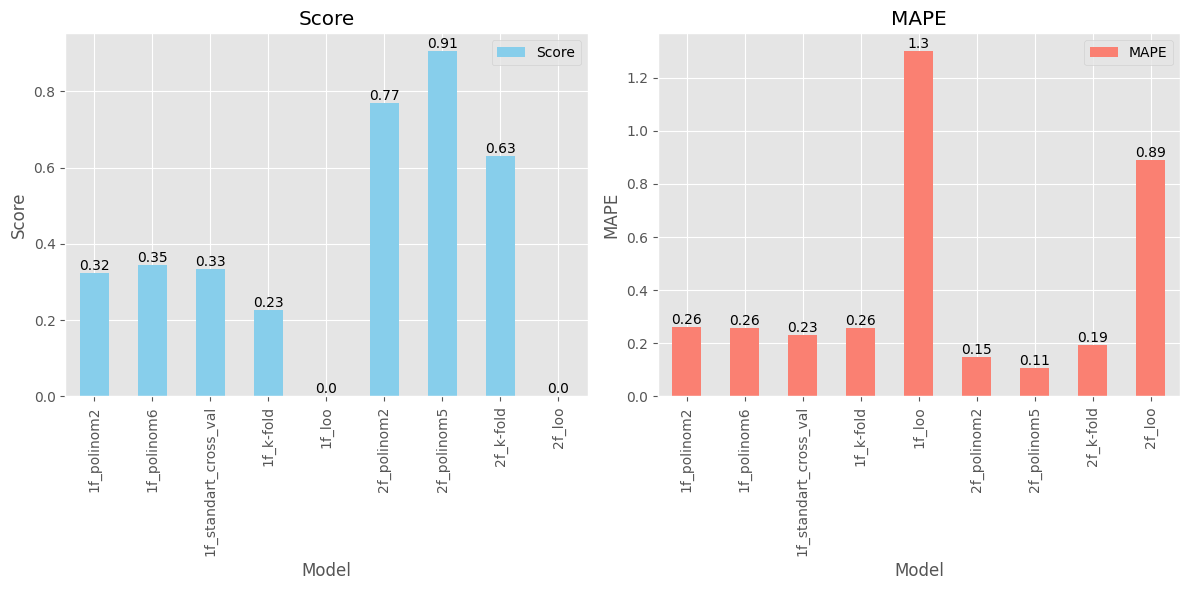

In [ ]:
df = df[df['Score'] >= 0]

# Заменяем NaN в столбце 'Score' на -1
df['Score'] = df['Score'].fillna(-1)

# Отобразим графики
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# График для Score
df_score = df[df['Score'] != -1]  # Удаляем только строки, где Score равен -1
df_score.plot(kind='bar', x='Model', y='Score', ax=axes[0], color='skyblue')
axes[0].set_title('Score')
axes[0].set_ylabel('Score')
# Выводим значения на вершинке каждого столбца
for i, value in enumerate(df_score['Score']):
    axes[0].text(i, value, str(round(value, 2)), ha='center', va='bottom')

# График для MAPE
df_mape = df.dropna(subset=['MAPE'])  # Удаляем строки, где MAPE равен NaN
df_mape.plot(kind='bar', x='Model', y='MAPE', ax=axes[1], color='salmon')
axes[1].set_title('MAPE')
axes[1].set_ylabel('MAPE')
# Выводим значения на вершинке каждого столбца
for i, value in enumerate(df_mape['MAPE']):
    axes[1].text(i, value, str(round(value, 2)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Вывод: по метрикам качества Score (R^2) и MAPE лучшей моделью в рамках данной задачи предсказания цены на жилье является многофакторная модель линейной регрессии, обученная на всех полиномиально преобразованных (с помощью полинома 5-ой степени) признаках.